### Data Mining on Hospital Dataset

This notebook looks at the Hospital dataset and builds a model to predict the onset of diabetes

### Imports

In [327]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import Imputer
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import matplotlib.patches as mpatches
from IPython.display import HTML
from operator import itemgetter


import pandas as pd
import numpy as np
import time


# pd.options.mode.chained_assignment = None 

### Helper functions

In [328]:
def print_bold(text):
    display(Markdown("**{}**".format(text)))
    
def print_color(text, color='red'):
    display(HTML("<text style=color:{}>{}</text>".format(color, text)))


def display_confusion_matrix(target_test, target_predict):
    print_bold('Confusion Matrix')
    y_actu = pd.Series(target_test, name='Actual')
    y_pred = pd.Series(target_predict, name='Predicted')
    print(pd.crosstab(y_actu, y_pred))
    
# Basic graph plotting utility
def plot_roc_curve(confusion_matrix_list, models, x_label, y_label, model_names=''):
    
    tpr_fpr_list = []
    
    for idx, cm in enumerate(confusion_matrix_list):
    
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        
        
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        print(models[idx][0], 'TPR:' + str(tpr), 'FPR:' + str(fpr))
    
        tpr_fpr_list.append((round(fpr, 2), round(tpr , 2)))
        
    tpr_fpr_list.sort(key=itemgetter(0))    
    handles = []
    
    for model_name, model, color in models:
        patch = mpatches.Patch(color=color, label=model_name)
        handles.append(patch)
        
    fpr_list, tpr_list = zip(*tpr_fpr_list)
    
    fig, ax = plt.subplots()
    plt.plot(fpr_list, tpr_list, 'bs-')
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    for idx, _   in enumerate(tpr_list):
        
        tpr = tpr_list[idx]
        fpr = fpr_list[idx]
#         plt.plot([fpr, fpr], [0, tpr], 'ks-') # vertical
#         plt.plot([0, fpr], [tpr, tpr], 'ks-') # horizontal
        plt.plot([fpr], [tpr], marker='o',  markersize=10, color=models[idx][2])
    plt.legend(handles=handles)
    plt.show()

### Read dataset

In [329]:
DATASET_NAME = 'datasets/diabetes_hospital.csv'
df = pd.read_csv(DATASET_NAME)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### Find out missing values in the dataset

In [330]:
attributes = ['race', 'gender', 'age', 'medical_specialty','change','diabetesMed', 'readmitted']
for attr in attributes:
    print(attr,": ", sum(df[attr] == '?'))

race :  2273
gender :  0
age :  0
medical_specialty :  49949
change :  0
diabetesMed :  0
readmitted :  0


### Show statistics of the dataset

In [331]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
admission_type_id,101766.0,2.024006e+00,1.445403e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,101766.0,3.715642e+00,5.280166e+00,1.0,1.0,1.0,4.000000e+00,28.0
admission_source_id,101766.0,5.754437e+00,4.064081e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0


### Drop columns
Drop attributes like IDs and other irrelevant attributes

In [332]:
bad_features = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'admission_type_id', 
                'discharge_disposition_id', 'admission_source_id', 'number_outpatient', 'number_emergency', 
                'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'examide', 
                'citoglipton', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 
                'metformin-rosiglitazone', 'metformin-pioglitazone', 'max_glu_serum', 'A1Cresult', 
                'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
                'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 
                'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton']
df.drop(bad_features, inplace=True, axis =1)

### Replace missing values

In [333]:
df['medical_specialty'] = df['medical_specialty'].replace(['?', ''], 'General')
df['race'] = df['race'].replace(['?', ''], 'Other')
df['readmitted'] = df['readmitted'].replace(['>30', '<30'], 'YES')
df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,101756,101757,101758,101759,101760,101761,101762,101763,101764,101765
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,...,Other,Caucasian,Caucasian,Caucasian,AfricanAmerican,AfricanAmerican,AfricanAmerican,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female,...,Female,Female,Female,Male,Female,Male,Female,Male,Female,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100),...,[60-70),[70-80),[80-90),[80-90),[60-70),[70-80),[80-90),[70-80),[80-90),[70-80)
time_in_hospital,1,3,2,2,1,3,4,5,13,12,...,2,5,5,1,6,3,5,1,10,6
medical_specialty,Pediatrics-Endocrinology,General,General,General,General,General,General,General,General,InternalMedicine,...,General,General,General,General,General,General,General,General,Surgery-General,General
num_lab_procedures,41,59,11,44,51,31,70,73,68,33,...,46,21,76,1,45,51,33,53,45,13
num_procedures,0,0,5,1,0,6,1,0,2,3,...,6,1,1,0,1,0,3,0,2,3
num_medications,1,18,13,16,8,16,21,12,28,18,...,17,16,22,15,25,16,18,9,21,3
insulin,No,Up,No,Up,Steady,Steady,Steady,No,Steady,Steady,...,Steady,Steady,Up,Up,Down,Down,Steady,Down,Up,No
change,No,Ch,No,Ch,Ch,No,Ch,No,Ch,Ch,...,No,No,Ch,Ch,Ch,Ch,No,Ch,Ch,No


### Categorical to numeric

In [334]:
dummy_columns = ['race', 'gender','age', 'insulin', 'medical_specialty']
df_dummies = pd.get_dummies(df, columns=dummy_columns)

df_target = df['readmitted']

# Drop the target variable from dataframe
df_dummies.drop('readmitted' , inplace = True, axis =1)
df_attr = df_dummies

# Concvert binary categorical values to numeric
df_attr['diabetesMed'] = pd.Categorical(df_attr['diabetesMed']).codes
df_attr['change'] = pd.Categorical(df_attr['change']).codes

df_attr.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,change,diabetesMed,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,...,medical_specialty_Surgery-General,medical_specialty_Surgery-Maxillofacial,medical_specialty_Surgery-Neuro,medical_specialty_Surgery-Pediatric,medical_specialty_Surgery-Plastic,medical_specialty_Surgery-PlasticwithinHeadandNeck,medical_specialty_Surgery-Thoracic,medical_specialty_Surgery-Vascular,medical_specialty_SurgicalSpecialty,medical_specialty_Urology
0,1,41,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,3,59,0,18,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,11,5,13,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,44,1,16,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,51,0,8,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Split attribues for training and testing

In [335]:
attr_train, attr_test, target_train, target_test = train_test_split(df_attr , df_target)

### Models
Fit various models and check results

In [336]:
models = [('Decision Tree', DecisionTreeClassifier(max_depth= 5), 'red'), 
          ('Logistic Regression', LogisticRegression(), 'green'), 
          ('Random Forest', RandomForestClassifier(), 'yellow'),
          ('Naive Bayes', GaussianNB(), 'magenta'),
          ('Neural Network', MLPClassifier(hidden_layer_sizes = 5,  max_iter= 500), 'blue')]
         

predicted_results = []
time_elapsed = []
for model_names, model, _ in models:
    
    start = time.time()
    
    model.fit(attr_train, target_train)
    target_predict = model.predict(attr_test)
    
    end = time.time()
    
    time_elapsed.append(end - start)
    predicted_results.append(target_predict)

### Results
Show the results of various models

In [337]:
fpr_list = []
tpr_list = []
confusion_matrix_list = []

for idx, (model_name, model, _) in enumerate(models):
    print_bold(model_name)
    print_bold('Accuracy Score')
    print(accuracy_score(target_test.values, predicted_results[idx]), end='\n\n')
    
    print_bold('Time taken')
    print(round(time_elapsed[idx], 3) , 'ms')
    
    display_confusion_matrix(target_test.values, predicted_results[idx])
    cm = confusion_matrix(target_test.values, predicted_results[idx])
    confusion_matrix_list.append(cm)
    
    print_bold('Classification Report')
    print(classification_report(target_test, predicted_results[idx]))

**Decision Tree**

**Accuracy Score**

0.559036239289



**Time taken**

0.372 ms


**Confusion Matrix**

Predicted     NO   YES
Actual                
NO         10630  3156
YES         8063  3593


**Classification Report**

             precision    recall  f1-score   support

         NO       0.57      0.77      0.65     13786
        YES       0.53      0.31      0.39     11656

avg / total       0.55      0.56      0.53     25442



**Logistic Regression**

**Accuracy Score**

0.571889002437



**Time taken**

1.275 ms


**Confusion Matrix**

Predicted    NO   YES
Actual               
NO         9940  3846
YES        7046  4610


**Classification Report**

             precision    recall  f1-score   support

         NO       0.59      0.72      0.65     13786
        YES       0.55      0.40      0.46     11656

avg / total       0.57      0.57      0.56     25442



**Random Forest**

**Accuracy Score**

0.5494064932



**Time taken**

1.49 ms


**Confusion Matrix**

Predicted    NO   YES
Actual               
NO         9401  4385
YES        7079  4577


**Classification Report**

             precision    recall  f1-score   support

         NO       0.57      0.68      0.62     13786
        YES       0.51      0.39      0.44     11656

avg / total       0.54      0.55      0.54     25442



**Naive Bayes**

**Accuracy Score**

0.489702067448



**Time taken**

0.332 ms


**Confusion Matrix**

Predicted    NO    YES
Actual                
NO         1569  12217
YES         766  10890


**Classification Report**

             precision    recall  f1-score   support

         NO       0.67      0.11      0.19     13786
        YES       0.47      0.93      0.63     11656

avg / total       0.58      0.49      0.39     25442



**Neural Network**

**Accuracy Score**

0.574758273721



**Time taken**

4.195 ms


**Confusion Matrix**

Predicted     NO   YES
Actual                
NO         11685  2101
YES         8718  2938


**Classification Report**

             precision    recall  f1-score   support

         NO       0.57      0.85      0.68     13786
        YES       0.58      0.25      0.35     11656

avg / total       0.58      0.57      0.53     25442



### Analysis

Decision Tree TPR:0.308253260124 FPR:0.228927897867
Logistic Regression TPR:0.395504461222 FPR:0.278978674017
Random Forest TPR:0.392673301304 FPR:0.318076309299
Naive Bayes TPR:0.934282772821 FPR:0.886188887277
Neural Network TPR:0.252059025395 FPR:0.152400986508


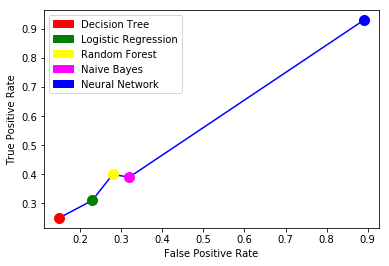

In [338]:
plot_roc_curve(confusion_matrix_list, models, 'False Positive Rate', 'True Positive Rate')